# Preamble

In [1]:
# Project functions
from utils.utils import *
from utils.network import *
from utils.visualization import *
from utils.info import *

# External imports
import numpy as np
import re
import subprocess
import networkx as nx
import random
from multiprocessing import Pool
from sklearn.metrics.cluster import adjusted_mutual_info_score

In [2]:
standarize_plot_parameters()

### Utility functions

In [3]:
def sample_from_graph(G, p):
    G_sample = nx.Graph()
    G_sample.add_nodes_from(G.nodes())
    G_sample.add_edges_from(random.sample(G.edges(), int(p*len(G.edges()))))
    return G_sample

def multilayer_network_with_L_samples(G_arr, L, shuf=False):
    """Take T independent networks and sample L subgraphs from each.
    
    Input
    -----
        G_arr : list of nx.Graph objects
        L : number (int) of subgraphs to create for each element in G_arr
        shuf : bool. whether or not to shuffle order of subgraphs
        
    Output
    ------
        out : str. pajek-formatted multilayer network
    """
    def _sample_from_graph(G, p):
        G_sample = nx.Graph()
        G_sample.add_nodes_from(G.nodes())
        G_sample.add_edges_from(random.sample(G.edges(), int(p*len(G.edges()))))
        return G_sample
    
    G_arr_sampled = []
    for G in G_arr:
        for _ in range(L):
            G_arr_sampled.append(_sample_from_graph(G, 1.0/2))
        
    if shuf:
        G_arr_sampled, order = shuffle_order(G_arr_sampled)
        return graph_list_to_pajek(G_arr_sampled), order

    return graph_list_to_pajek(G_arr_sampled)
    
def multiplex_AMI(layer_commu, L, partitions):
    """Compute multiplex AMI of 
    """
    multilayer_partition_true = dict()
    multilayer_partition_pred = dict()
    for i in range(len(partitions)):
        for l in range(L):
            layer = i*L + l
            multilayer_partition_true.update(
                dict(
                    (str(layer) + str(n), int(str(i) + str(c)))
                    for n, c in partitions[i].items()
                )
            )
            multilayer_partition_pred.update(
                dict(
                    (str(layer) + str(n), c)
                    for n, c in invert_partition(layer_commu[layer]).items()
                )
            )
    return AMI_score(multilayer_partition_true, multilayer_partition_pred)

def method_args(method, r):
    return {
        'FC': ['--multiplex-relax-rate', str(r)],
        'NC': ['--multiplex-relax-rate', '0', '--multiplex-relax-limit', '1'],
        'NFC': ['--multiplex-js-relax-rate', str(r)],
        'AC': ['--multiplex-relax-rate', str(r), '--multiplex-relax-limit', '1']
    }[method]


def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

# Analysis

## Choose benchmark network

We want a benchmark network with significant clustering and some but not too much overlap between communities in independent modes. There should also be enough links inside of communities so that we can make quite sparse samples of networks without losing the planted community structure.

#### Hyperparameters

In [4]:
LFR_params = dict(N=512, k=10, maxk=24, mu=0.05, t1=10, t2=10, maxc=24)

#### Plot an example of that network

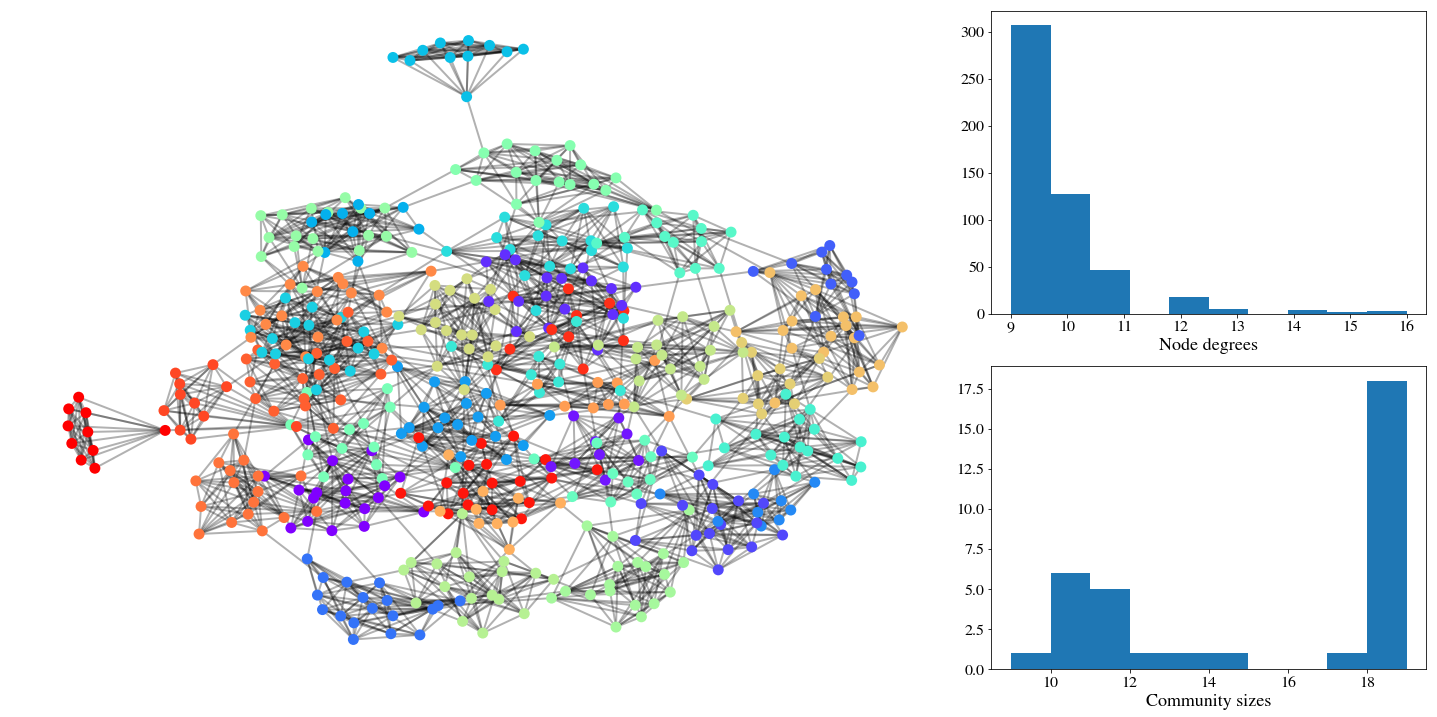

In [8]:
# An example of what a mode looks like
G_example, partition_example = LFR_benchmark_graph(**LFR_params)

plt.figure(figsize=(20, 10))

plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=2)
draw(G_example, partition=partition_example)

plt.subplot2grid((2, 3), (0, 2))
plt.hist([d for n, d in G_example.degree()])
plt.xlabel("Node degrees", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot2grid((2, 3), (1, 2))
plt.hist([len(nodes) for n, nodes in invert_partition(partition_example).items()])
plt.xlabel("Community sizes", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()

#### How strongly coupled are independent modes?

utils/info.py:22: RuntimeWarning: divide by zero encountered in log2
  return np.sum([v for v in A * np.log2(A * 1.0 / B) if not np.isnan(v)])
utils/info.py:22: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log2(A * 1.0 / B) if not np.isnan(v)])


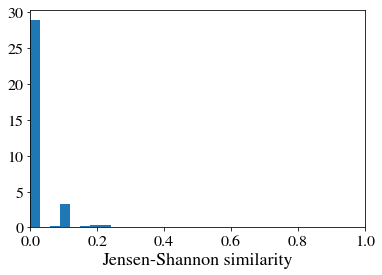

In [5]:
G1 = LFR_benchmark_graph(**LFR_params)[0]
G2 = LFR_benchmark_graph(**LFR_params)[0]

plt.figure(figsize=(6, 4))
plt.hist(jssim_dist(G1, G2), normed=True)
plt.xlabel("Jensen-Shannon similarity", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 1)
plt.show()

This is nice. A small amount og neighborhood similarity.

#### How strongly coupled are samples from the same mode?

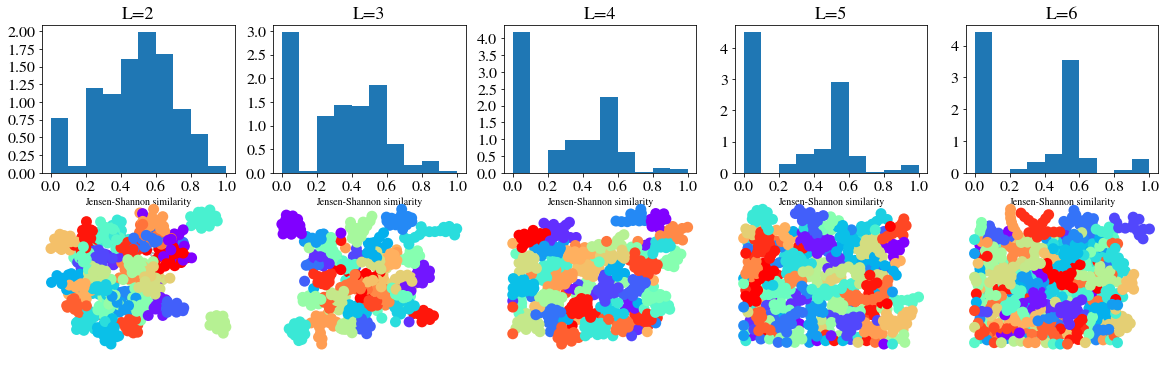

In [8]:
G, partition = LFR_benchmark_graph(**LFR_params)
L_arr = [2, 3, 4, 5, 6]

plt.figure(figsize=(20, 6))
for i, L in enumerate(L_arr, 1):
    
    sims = []
    for _ in range(L*(L-1)/2):
        G_sample1 = sample_from_graph(G, 1./L)
        G_sample2 = sample_from_graph(G, 1./L)
        sims.extend(jssim_dist(G_sample1, G_sample2, nodes=G.nodes()))

    plt.subplot(2, len(L_arr), i)
    plt.title("L=%d" % L, fontsize=18)
    plt.hist(sims, normed=True)
    plt.xlabel("Jensen-Shannon similarity")
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.subplot(2, len(L_arr), len(L_arr) + i)
    draw(G_sample1, partition)
    
plt.show()

As L increases, the network samples becomes increasingly sparse. This makes nodeneighborhood similarities between samples of the same node in different layers smaller and smaller, but never so small that there is none, even for high L. We see for L=6 that the clusters are less connected (because the force layout lets the nodes fill the whole space) but nodes are still connected by community.

## Fig 4.d-e

### Experiment

In [5]:
def worker(args):
    """Worker function for running Infomap. Enables parallelization."""
    if len(args) == 4: # Shuffled
        args, L, partitions, order = args
        _, _layer_commu, _, _ = Infomap(*args)
        _layer_commu = reorder_shuffled_layer_commu(_layer_commu, order)
    else:
        args, L, partitions = args
        _, _layer_commu, _, _ = Infomap(*args)
    return multiplex_AMI(_layer_commu, L, partitions), args[-1][3:]
    
def AMI_vs_L(G_arr, L_arr, partitions, parallel, n_procs):
    """Compute the multiplex AMI of NFC, FC, AC and NC for a range of L values (sparsity).
    
    Input
    -----
        G_arr : list of nx.Graph
            Length of G_arr is T, and each nx.Graph corresponds to an independent mode.
        partitions : list of dicts
            Each dict gives the partition of a mode.
        L_max : int
            Maximum value of L to test. (independent variable max)
        parallel : bool (for debugging)
        
    Output
    ------
        out : tuple
            lists: `AMI_NFC`, `AMI_FC`, `AMI_AC`, `AMI_ACshuf`, `AMI_NC`. Each list
            contains multiplex AMI for the range of tested L values.
    """
    AMI_NFC, AMI_FC, AMI_AC, AMI_ACshuf, AMI_NC = [], [], [], [], []
    
    data = []    
    
    for L in L_arr:
        pajek_synth = multilayer_network_with_L_samples(G_arr, L)
        pajek_synth_shuf, order = multilayer_network_with_L_samples(G_arr, L, shuf=True)
        
        for method in ['NFC', 'FC', 'AC', 'NC']:
            data.append([[
                pajek_synth,
                '-i',
                'multiplex'
            ] + method_args(method, 0.25) + [
                '--overlapping',
                '--expanded',
                '--clu',
                '--two-level',
                '-z',
                'pid%s_L%d' % (method, L)
            ], L, partitions])

        data.append([[
            pajek_synth_shuf,
            '-i',
            'multiplex'
        ] + method_args("AC", 0.25) + [
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidACshuf_L%d' % L
        ], L, partitions, order])
    
    if parallel:
        print "\t... Pooling %d processes" % len(data)
        p = Pool(n_procs)
        processes = p.map(worker, data)
        p.close()
    else:
        print "\t... Processing serially"
        processes = map(worker, data)
    
    print "\t--> DONE! Extracting data and returning output"
    for output in processes:
        measured_AMI, pid = output
        method = pid.split("_")[0]
        locals()['AMI_%s' % method].append(measured_AMI)
    
    return AMI_NFC, AMI_FC, AMI_AC, AMI_ACshuf, AMI_NC

def run_simulation(T, L_arr, LFR_params, n_iter, parallel, n_procs, *args):    
    if args == ():
        NFC, FC, AC, ACshuf, NC = [], [], [], [], []
    else:
        NFC, FC, AC, ACshuf, NC = args
        
    for i in range(n_iter):
        G_arr, partitions = map(
            list,
            zip(*[LFR_benchmark_graph(**LFR_params) for _ in range(T)])
        )
        while True:
            try:
                AMI_NFC, AMI_FC, AMI_AC, AMI_ACshuf, AMI_NC = AMI_vs_L(G_arr, L_arr, partitions, parallel, n_procs)
                break
            except KeyError:
                print "KeyError",
                
        NFC.append(AMI_NFC)
        FC.append(AMI_FC)
        AC.append(AMI_AC)
        ACshuf.append(AMI_ACshuf)
        NC.append(AMI_NC)
        
    return NFC, FC, AC, ACshuf, NC

### Parameters

In [24]:
L_arr = range(1, 13)

### Run

In [28]:
# Technical parameters
parallel = True
n_procs = 56
n_iter = 10

# Run experiments
#for T in [1, 3, 10, 20]:
for T in [10]:
    [
        globals()["NFC_T%d" % T],
        globals()["FC_T%d" % T],
        globals()["AC_T%d" % T],
        globals()["ACshuf_T%d" % T],
        globals()["NC_T%d" % T]
    ] = run_simulation(T, L_arr, LFR_params, n_iter, parallel, n_procs)

	... Pooling 60 processes
	--> DONE! Extracting data and returning output
	... Pooling 60 processes
	--> DONE! Extracting data and returning output
	... Pooling 60 processes
	--> DONE! Extracting data and returning output
	... Pooling 60 processes
	--> DONE! Extracting data and returning output
	... Pooling 60 processes
	--> DONE! Extracting data and returning output
	... Pooling 60 processes
	--> DONE! Extracting data and returning output
	... Pooling 60 processes
	--> DONE! Extracting data and returning output
	... Pooling 60 processes
	--> DONE! Extracting data and returning output
	... Pooling 60 processes
	--> DONE! Extracting data and returning output
	... Pooling 60 processes
	--> DONE! Extracting data and returning output


### Visualize

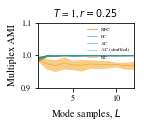

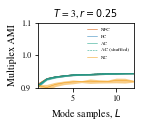

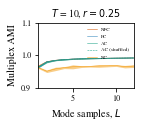

KeyError: 'NFC_T20'

In [30]:
for T in [1, 3, 10, 20]:

    X = [L_arr]
    
    plt.figure(figsize=(3.42/2, 2.4/2))
    confidence_intervals(X, globals()["NFC_T%d" % T], c="#d35400", label="NFC", lw=0.5)
    confidence_intervals(X, globals()["FC_T%d" % T], "#2980b9", label="FC", lw=0.5)
    confidence_intervals(X, globals()["AC_T%d" % T], c="#16a085", label="AC", lw=0.5)
    confidence_intervals(X, globals()["ACshuf_T%d" % T], c="#16a085", label="AC (shuffled)", lw=0.5, ls="--")
    confidence_intervals(X, globals()["NC_T%d" % T], c="#f39c12", label="NC", lw=0.5)
    
    plt.xlim(1, max(L_arr))
    plt.ylim(0.9, 1.1)
    
    plt.title("$T$ = %d, $r = 0.25$" % T)
    plt.xlabel("Mode samples, $L$")
    plt.ylabel("Multiplex AMI")

    plt.legend(loc="upper right", fontsize=5, frameon=False)
    #plt.savefig("figures/Fig4deT%d.pdf" % T)
    plt.show()
    

## Fig b

### Experiment

In [6]:
def worker(args):
    """Worker function for running Infomap. Enables parallelization."""
    if len(args) == 5: # Shuffled
        args, r, L, partitions, order = args
        _, _layer_commu, _, _ = Infomap(*args)
        _layer_commu = reorder_shuffled_layer_commu(_layer_commu, order)
    else:
        args, r, L, partitions = args
        _, _layer_commu, _, _ = Infomap(*args)
    return multiplex_AMI(_layer_commu, L, partitions), args[-1][3:]
    
def AMI_vs_r(T, L, r_arr, LFR_params, parallel, n_procs):
    """Compute the multiplex AMI of NFC, FC, AC and NC for a range of L values (sparsity).
    
    Input
    -----
        G_arr : list of nx.Graph
            Length of G_arr is T, and each nx.Graph corresponds to an independent mode.
        partitions : list of dicts
            Each dict gives the partition of a mode.
        L_max : int
            Maximum value of L to test. (independent variable max)
        parallel : bool (for debugging)
        
    Output
    ------
        out : tuple
            lists: `AMI_NFC`, `AMI_FC`, `AMI_AC`, `AMI_ACshuf`, `AMI_NC`. Each list
            contains multiplex AMI for the range of tested L values.
    """
    AMI_NFC, AMI_FC, AMI_AC, AMI_ACshuf, AMI_NC = [], [], [], [], []
    
    data = []    
    
    G_arr, partitions = map(
        list,
        zip(*[LFR_benchmark_graph(**LFR_params) for _ in range(T)])
    )
    
    pajek_synth = multilayer_network_with_L_samples(G_arr, L)
    pajek_synth_shuf, order = multilayer_network_with_L_samples(G_arr, L, shuf=True)
        
    for r in r_arr:
        
        for method in ['NFC', 'FC', 'AC', 'NC']:
            data.append([[
                pajek_synth,
                '-i',
                'multiplex'
            ] + method_args(method, r) + [
                '--overlapping',
                '--expanded',
                '--clu',
                '--two-level',
                '-z',
                'pid%s_r%s' % (method, str(r))
            ], r, L, partitions])

        data.append([[
            pajek_synth_shuf,
            '-i',
            'multiplex'
        ] + method_args("AC", r) + [
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidACshuf_r%s' % str(r)
        ], r, L, partitions, order])
    
    if parallel:
        print "\t... Pooling %d processes" % len(data)
        p = Pool(n_procs)
        processes = p.map(worker, data)
        p.close()
    else:
        print "\t... Processing serially"
        processes = map(worker, data)
    
    print "\t--> DONE! Extracting data and returning output"
    for output in processes:
        measured_AMI, pid = output
        method = pid.split("_")[0]
        locals()['AMI_%s' % method].append(measured_AMI)
    
    return AMI_NFC, AMI_FC, AMI_AC, AMI_ACshuf, AMI_NC


def run_simulation(T, L, r_arr, LFR_params, n_iter, parallel, n_procs, *args):    
    if args == ():
        NFC, FC, AC, ACshuf, NC = [], [], [], [], []
    else:
        NFC, FC, AC, ACshuf, NC = args
        
    for i in range(n_iter):
        while True:
            try:
                AMI_NFC, AMI_FC, AMI_AC, AMI_ACshuf, AMI_NC = AMI_vs_r(T, L, r_arr, LFR_params, parallel, n_procs)
                break
            except KeyError:
                print "KeyError",
                
        NFC.append(AMI_NFC)
        FC.append(AMI_FC)
        AC.append(AMI_AC)
        ACshuf.append(AMI_ACshuf)
        NC.append(AMI_NC)
        
    return NFC, FC, AC, ACshuf, NC

### Parameters

In [7]:
r_arr = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.999]

### Run

In [10]:
# Technical parameters
parallel = True
n_procs = 56
n_iter = 10

# Technical parameters
#for T in [3, 10, 20, 50]:
for T in [3]:
    for L in [10, 20, 50]:
        [
            globals()["NFC_T%dL%d" % (T, L)],
            globals()["FC_T%dL%d" % (T, L)],
            globals()["AC_T%dL%d" % (T, L)],
            globals()["ACshuf_T%dL%d" % (T, L)],
            globals()["NC_T%dL%d" % (T, L)]
        ] = run_simulation(T, L, r_arr, LFR_params, n_iter, parallel, n_procs)

	... Pooling 105 processes
	--> DONE! Extracting data and returning output
	... Pooling 105 processes
	--> DONE! Extracting data and returning output
	... Pooling 105 processes
	--> DONE! Extracting data and returning output
	... Pooling 105 processes
	--> DONE! Extracting data and returning output
	... Pooling 105 processes
	--> DONE! Extracting data and returning output
	... Pooling 105 processes
	--> DONE! Extracting data and returning output
	... Pooling 105 processes
	--> DONE! Extracting data and returning output
	... Pooling 105 processes
	--> DONE! Extracting data and returning output
	... Pooling 105 processes
	--> DONE! Extracting data and returning output
	... Pooling 105 processes
	--> DONE! Extracting data and returning output
	... Pooling 105 processes
	--> DONE! Extracting data and returning output
	... Pooling 105 processes
	--> DONE! Extracting data and returning output
	... Pooling 105 processes
	--> DONE! Extracting data and returning output
	... Pooling 105 processe

### Visualize

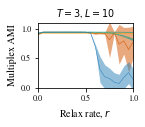

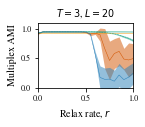

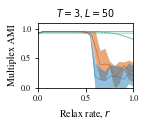

In [11]:
#for T in [3, 10, 20, 50]:
for T in [3]:
    for L in [10, 20, 50]:
        plt.figure(None, figsize=(3.42/2.0, 1.2), frameon=False)

        plt.plot(r_arr, [np.mean(globals()['NC_T%dL%d' % (T, L)])]*len(r_arr), c="#f39c12", lw=0.5)
        confidence_intervals([r_arr], globals()['NFC_T%dL%d' % (T, L)], c="#d35400", label=T, lw=0.5)
        confidence_intervals([r_arr], globals()['AC_T%dL%d' % (T, L)], c="#16a085", label=T, lw=0.5)
        confidence_intervals([r_arr], globals()['ACshuf_T%dL%d' % (T, L)], c="#16a085", label=T, lw=0.5, ls="--")
        confidence_intervals([r_arr], globals()['FC_T%dL%d' % (T, L)], c="#2980b9", label=T, lw=0.5)

        plt.xlim(0, 1.0)
        plt.ylim(0, 1.1)

        plt.title("$T=%d$, $L=%d$" % (T, L))
        plt.xlabel("Relax rate, $r$")
        plt.ylabel("Multiplex AMI")

        plt.savefig("figures/Fig4bT%dL%d.pdf" % (T, L))
        plt.show()

## Fig. 4c

### Experiment

In [ ]:
def worker(args):
    """Worker function for running Infomap. Enables parallelization."""
    if len(args) == 4: # Shuffled
        args, L, partitions, order = args
        _, _layer_commu, _, _ = Infomap(*args)
        _layer_commu = reorder_shuffled_layer_commu(_layer_commu, order)
    else:
        args, L, partitions = args
        _, _layer_commu, _, _ = Infomap(*args)
    return multiplex_AMI(_layer_commu, L, partitions), args[-1][3:]
    
def AMI_vs_T(T_arr, L, parallel, n_procs):
    """Compute the multiplex AMI of NFC, FC, AC and NC for a range of L values (sparsity).
    
    Input
    -----
        T_arr : list of ints
            T values to test (independent variable)
        L : int
            Number of samples to use
        parallel : bool (for debugging)
        n_procs : int (number of processes if parallel)
        
    Output
    ------
        out : tuple
            lists: `AMI_NFC`, `AMI_FC`, `AMI_AC`, `AMI_ACshuf`, `AMI_NC`. Each list
            contains multiplex AMI for the range of tested T values.
    """
    
    AMI_NFC, AMI_FC, AMI_AC, AMI_ACshuf, AMI_NC = [], [], [], [], []
    
    print "\t... Preparing input data"
    
    data = []
    for T in log_progress(T_arr, every=1):
        
        G_arr, partitions = map(
            list,
            zip(*[LFR_benchmark_graph(**LFR_params) for _ in range(T)])
        )
        
        pajek_synth = multilayer_network_with_L_samples(G_arr, L)
        pajek_synth_shuf, order = multilayer_network_with_L_samples(G_arr, L, shuf=True)
        
        for method in ['NFC', 'FC', 'AC', 'NC']:
            data.append([[
                pajek_synth,
                '-i',
                'multiplex'
            ] + method_args(method, 0.25) + [
                '--overlapping',
                '--expanded',
                '--clu',
                '--two-level',
                '-z',
                'pid%s_T%d' % (method, T)
            ], L, partitions])

        data.append([[
            pajek_synth_shuf,
            '-i',
            'multiplex'
        ] + method_args("AC", 0.25) + [
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidACshuf_T%d' % T
        ], L, partitions, order])
    
    if parallel:
        print "\t... Pooling %d processes" % len(data)
        p = Pool(n_procs)
        processes = p.map(worker, data)
        p.close()
    else:
        print "\t... Processing serially"
        processes = map(worker, data)
    
    print "\t--> DONE! Extracting data and returning output"
    for output in processes:
        measured_AMI, pid = output
        method = pid.split("_")[0]
        locals()['AMI_%s' % method].append(measured_AMI)
    
    return AMI_NFC, AMI_FC, AMI_AC, AMI_ACshuf, AMI_NC

def run_simulation(T_arr, L, LFR_params, parallel, n_procs, n_iter, *args):
    
    if args == ():
        NFC, FC, AC, ACshuf, NC = [], [], [], [], []
    else:
        NFC, FC, AC, ACshuf, NC = args
        
    for i in range(n_iter):

        while True:
            try:
                AMI_NFC, AMI_FC, AMI_AC, AMI_ACshuf, AMI_NC = AMI_vs_T(T_arr, L, parallel, 8)
                break
            except KeyError:
                print "KeyError",
                
        NFC.append(AMI_NFC)
        FC.append(AMI_FC)
        AC.append(AMI_AC)
        ACshuf.append(AMI_ACshuf)
        NC.append(AMI_NC)
        print i,
        
    return NFC, FC, AC, ACshuf, NC

### Parameters

In [ ]:
T_arr = range(1, 10) + range(10, 20, 2) + range(20, 30, 5) + range(30, 60, 10)

### Run

In [ ]:
for L in [3, 5]:
    globals()['NFCL%d' % L], globals()['FCL%d' % L], globals()['ACL%d' % L], globals()['ACshufL%d' % L], globals()['NCL%d' % L] = run_simulation(T_arr, L, LFR_params, True, 8, 8)  # 1 iteration about takes 8m 31sNFCL5, FCL5, ACL5, ACshufL5, NCL5 = run_simulation(T_arr, L, LFR_params, True, 8, 40)  # 1 iteration about takes 8m 31s

### Visualize

In [ ]:
for L in [3, 5]:
    plt.figure(None, figsize=(3.42/2, 2.4/2), frameon=False)

    confidence_intervals([T_arr], globals()['NFCL%d' % L], c="#d35400", label="NFC", lw=0.5)
    confidence_intervals([T_arr], globals()['FCL%d' % L], c="#2980b9", label="FC", lw=0.5)
    confidence_intervals([T_arr], globals()['ACL%d' % L], c="#16a085", label="AC", lw=0.5)
    confidence_intervals([T_arr], globals()['ACshufL%d' % L], c="#16a085", label="AC (shuffled)", lw=0.5, ls="--")
    confidence_intervals([T_arr], globals()['NCL%d' % L], c="#f39c12", label="NC", lw=0.5)

    plt.xlim(0, 50)
    plt.ylim(0.0, 1)

    #plt.yticks([0.7, 0.8, 0.9, 1.0]) 

    plt.title("$L=%d$" % L)
    plt.xlabel("Network modes, $T$")
    plt.ylabel("Multiplex AMI")

    plt.savefig("figures/Fig4cL%d.pdf" % L)
    plt.show()